In [ ]:
!tar -xvf /content/TCGA-PANCAN-HiSeq-801x20531.tar.gz

TCGA-PANCAN-HiSeq-801x20531/
TCGA-PANCAN-HiSeq-801x20531/data.csv
TCGA-PANCAN-HiSeq-801x20531/labels.csv


Missing values in data: 0
Missing values in labels: 0


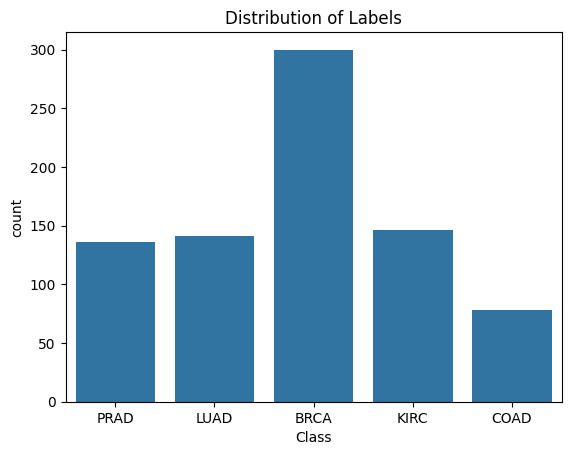

  Class
0  BRCA
1  BRCA
2  BRCA
3  LUAD
4  COAD


<ipython-input-3-62480c1c5f6a>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_resampled, y_train_resampled)


Accuracy: 0.9813664596273292
              precision    recall  f1-score   support

        BRCA       0.97      0.98      0.98        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      0.96      0.98        25
        LUAD       0.97      1.00      0.98        29
        PRAD       1.00      0.97      0.98        29

    accuracy                           0.98       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



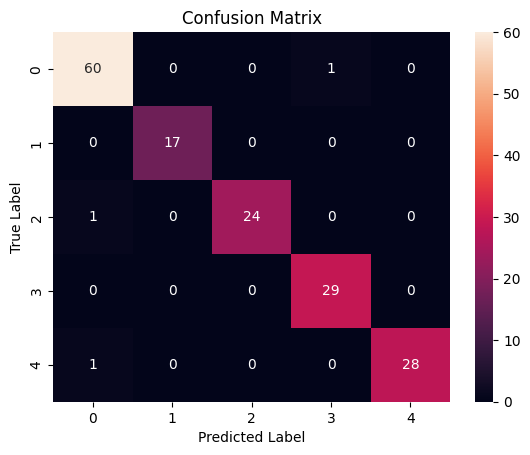

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Step 1: Read the data from CSV files into pandas DataFrames
data_df = pd.read_csv('/content/TCGA-PANCAN-HiSeq-801x20531/data.csv')
labels_df = pd.read_csv('/content/TCGA-PANCAN-HiSeq-801x20531/labels.csv')

# Step 2: Preprocessing

# Assuming the first column is the sample ID and should be set as the index
data_df.set_index(data_df.columns[0], inplace=True)
labels_df.set_index(labels_df.columns[0], inplace=True)

# Check for missing values
print("Missing values in data:", data_df.isnull().sum().sum())
print("Missing values in labels:", labels_df.isnull().sum().sum())

# Check the distribution of labels
sns.countplot(x=labels_df.iloc[:,0])
plt.title('Distribution of Labels')
plt.show()

# Step 3: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(data_df, labels_df, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Dimensionality Reduction (Optional)
# You can use PCA to reduce the number of features
pca = PCA(n_components=50)  # Choose the number of principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 6: Use SMOTE to handle imbalanced data
class_counts_before = y_train['Class'].value_counts()
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
print(y_train_resampled.head())


# Step 7: Model Training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Step 8: Model Evaluation
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


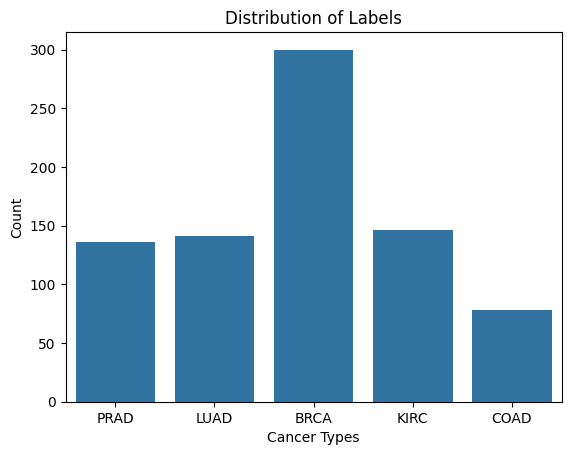

In [ ]:
sns.countplot(x=labels_df.iloc[:,0])
plt.title('Distribution of Labels')
plt.xlabel('Cancer Types')
plt.ylabel('Count')
plt.show()


Class Counts Before SMOTE:
BRCA    239
KIRC    121
LUAD    112
PRAD    107
COAD     61
Name: Class, dtype: int64

Class Counts After SMOTE:
BRCA    239
LUAD    239
COAD    239
KIRC    239
PRAD    239
Name: Class, dtype: int64


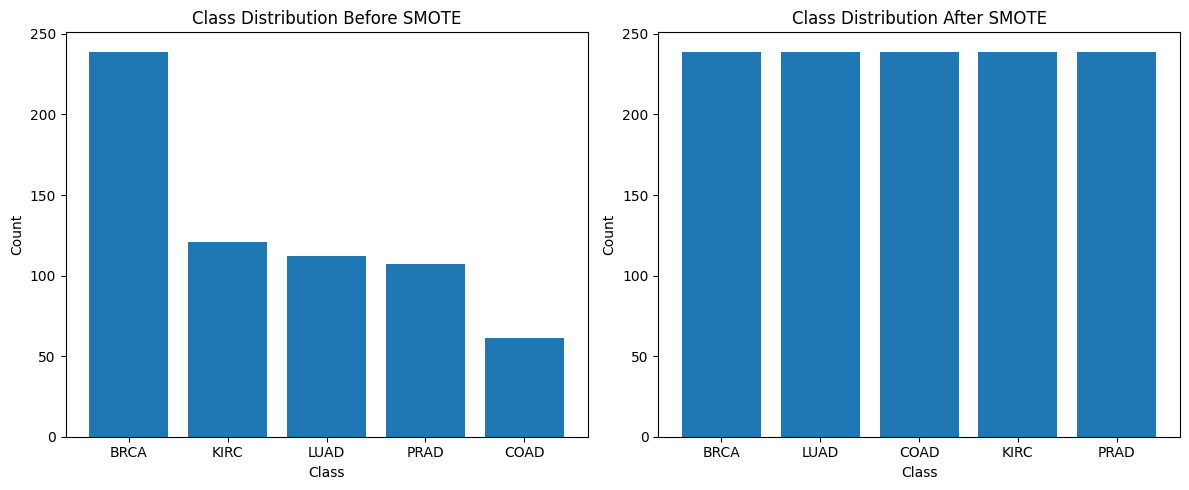

In [ ]:
# Count the number of datapoints for each class before SMOTE
class_counts_before = y_train['Class'].value_counts()

# Display classes and their datapoints before SMOTE
print("Class Counts Before SMOTE:")
print(class_counts_before)
class_counts_after = y_train_resampled['Class'].value_counts()


# Display classes and their datapoints after SMOTE
print("\nClass Counts After SMOTE:")
print(class_counts_after)

# Create subplots for before and after SMOTE
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot before SMOTE
axs[0].bar(class_counts_before.index, class_counts_before.values)
axs[0].set_title('Class Distribution Before SMOTE')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

# Plot after SMOTE
axs[1].bar(class_counts_after.index, class_counts_after.values)
axs[1].set_title('Class Distribution After SMOTE')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
